In [13]:
import tensorflow as tf
import cv2
import numpy as np

print("TF:", tf.__version__)
print("OpenCV:", cv2.__version__)
print("NumPy:", np.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))


TF: 2.20.0
OpenCV: 4.12.0
NumPy: 2.2.6
GPU devices: []


In [14]:
#STEP 1A — Verify dataset structure
from pathlib import Path

DATA_DIR = Path("C:/Users/Admin/SAS-sign-to-text/Data/train")

classes = sorted([d.name for d in DATA_DIR.iterdir() if d.is_dir()])

print("Classes:", classes)
print("Number of classes:", len(classes))


Classes: ['0', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Number of classes: 27


In [15]:
#STEP 1B — Count images per class (very important)
import os

for cls in classes:
    count = len(os.listdir(DATA_DIR / cls))
    print(f"{cls}: {count} images")



0: 465 images
A: 468 images
B: 473 images
C: 469 images
D: 466 images
E: 468 images
F: 498 images
G: 462 images
H: 495 images
I: 471 images
J: 500 images
K: 492 images
L: 465 images
M: 495 images
N: 490 images
O: 501 images
P: 465 images
Q: 464 images
R: 473 images
S: 465 images
T: 467 images
U: 462 images
V: 495 images
W: 471 images
X: 461 images
Y: 474 images
Z: 470 images


In [16]:
#Code Cell 1 — set paths + labels
import os
from pathlib import Path

# ✅ EDIT THIS: the folder that contains A/, B/, C/ ... Z/
DATA_DIR = Path(r"C:/Users/Admin/SAS-sign-to-text/Data/train")  # مثال: ...\SASL_dataset\train

# labels A-Z (you can add 'space' later if your dataset has it)
LABELS = [chr(ord('A') + i) for i in range(26)]

print("DATA_DIR exists:", DATA_DIR.exists())
print("Example class folder:", (DATA_DIR / "A").exists())


DATA_DIR exists: True
Example class folder: True


In [17]:
#Code Cell 3 — define paths + basic settings
from pathlib import Path
import tensorflow as tf

# EDIT if your project folder is different
TRAIN_DIR = Path(r"C:/Users/Admin/SAS-sign-to-text/Data/train")
VAL_DIR   = Path(r"C:/Users/Admin/SAS-sign-to-text/Data/val")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

print("Train exists:", TRAIN_DIR.exists())
print("Val exists:", VAL_DIR.exists())


Train exists: True
Val exists: True


In [18]:
#Code Cell 4 — load datasets using tf.keras
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

class_names = train_ds.class_names
print("Class names:", class_names)
print("Number of classes:", len(class_names))


Found 12845 files belonging to 27 classes.
Found 4268 files belonging to 27 classes.
Class names: ['0', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Number of classes: 27


In [19]:
#Code Cell 5 — performance + normalization
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)



In [20]:
#Code Cell 6 — data augmentation (train only)
data_augmentation = tf.keras.Sequential([
       tf.keras.layers.RandomFlip("horizontal"),
       tf.keras.layers.RandomRotation(0.08),
       tf.keras.layers.RandomZoom(0.10),
       tf.keras.layers.RandomTranslation(0.05, 0.05),
    tf.keras.layers.RandomContrast(0.15),
], name="augmentation")

In [21]:
def make_grayscale_3ch(images, labels):
    # images: (B,224,224,3)
    gray = tf.image.rgb_to_grayscale(images)      # (B,224,224,1)
    gray3 = tf.repeat(gray, repeats=3, axis=-1)   # (B,224,224,3)
    return gray3, labels

train_ds = train_ds.map(make_grayscale_3ch, num_parallel_calls=AUTOTUNE)
val_ds   = val_ds.map(make_grayscale_3ch,   num_parallel_calls=AUTOTUNE)


In [12]:
for x, y in train_ds.take(1):
    print("Batch images:", x.shape, "Batch labels:", y.shape)


Batch images: (32, 224, 224, 3) Batch labels: (32,)


In [22]:
import tensorflow as tf
from tensorflow import keras

TRAIN_DIR = r"C:/Users/Admin/SAS-sign-to-text/Data/train"
VAL_DIR   = r"C:/Users/Admin/SAS-sign-to-text/Data/val"

IMG_SIZE = (224, 224)
BATCH_SIZE = 16   # 🔥 lower to reduce crashes
SEED = 123

train_ds = keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_ds = keras.utils.image_dataset_from_directory(
    VAL_DIR,
    labels="inferred",
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)

print("Num classes:", num_classes)
print("First 5 classes:", class_names[:5])


Found 12845 files belonging to 27 classes.
Found 4268 files belonging to 27 classes.
Num classes: 27
First 5 classes: ['0', 'A', 'B', 'C', 'D']


In [2]:
for x, y in train_ds.take(1):
    print("Images:", x.shape)
    print("Labels:", y.shape)  # should be (BATCH_SIZE, num_classes)


Images: (16, 224, 224, 3)
Labels: (16, 27)


In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ---- settings to reduce crashes ----
BATCH_SIZE = 8            # lower if still crashing (try 4)
IMG_SIZE = (224, 224)

AUTOTUNE = tf.data.AUTOTUNE

# (optional) safer pipeline: cache to disk instead of RAM
train_ds = train_ds.shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)

# ---- augmentation (keep it light) ----
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.08),
], name="augmentation")

# ---- grayscale -> 3ch (needed for pretrained models) ----
def make_grayscale_3ch(images, labels):
    gray = tf.image.rgb_to_grayscale(images)      # (B,224,224,1)
    gray3 = tf.repeat(gray, repeats=3, axis=-1)   # (B,224,224,3)
    return gray3, labels

train_ds_g = train_ds.map(make_grayscale_3ch, num_parallel_calls=AUTOTUNE)
val_ds_g   = val_ds.map(make_grayscale_3ch, num_parallel_calls=AUTOTUNE)

# ---- build MobileNetV2 transfer model ----
base = keras.applications.MobileNetV2(
    include_top=False,
    input_shape=IMG_SIZE + (3,),
    weights="imagenet"
)
base.trainable = False

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = keras.applications.mobilenet_v2.preprocess_input(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 27)             │        34,587 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,292,571 (8.75 MB)

 Trainable params: 34,587 (135.11 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [25]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.5),
]

history = model.fit(
    train_ds_g,
    validation_data=val_ds_g,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 309s 378ms/step - accuracy: 0.9984 - loss: 0.0084 - val_accuracy: 0.9932 - val_loss: 0.0275 - learning_rate: 0.0010
Epoch 2/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 467s 574ms/step - accuracy: 0.9990 - loss: 0.0056 - val_accuracy: 0.9888 - val_loss: 0.0321 - learning_rate: 0.0010
Epoch 3/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 340s 416ms/step - accuracy: 0.9995 - loss: 0.0029 - val_accuracy: 0.9925 - val_loss: 0.0272 - learning_rate: 0.0010
Epoch 4/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 340s 415ms/step - accuracy: 0.9995 - loss: 0.0030 - val_accuracy: 0.9977 - val_loss: 0.0105 - learning_rate: 0.0010
Epoch 5/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 339s 414ms/step - accuracy: 0.9993 - loss: 0.0032 - val_accuracy: 0.9979 - val_loss: 0.0119 - learning_rate: 0.0010
Epoch 6/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 598s 738ms/step - accuracy: 0.9994 - loss: 0.0024 - val_accuracy: 0.9955 - val_loss: 0.0146 - learning_rate: 0.0010
Epoch 7/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 302s 368ms/step - accura

In [26]:
model.save("sasl_mobilenet_v2.keras")


In [27]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [28]:
# Collect true labels and predictions
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


In [29]:
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix shape:", cm.shape)


Confusion matrix shape: (27, 27)


In [30]:
def plot_confusion_matrix(cm, class_names, normalize=False):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix" + (" (Normalized)" if normalize else ""))
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j, i, format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black"
            )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()


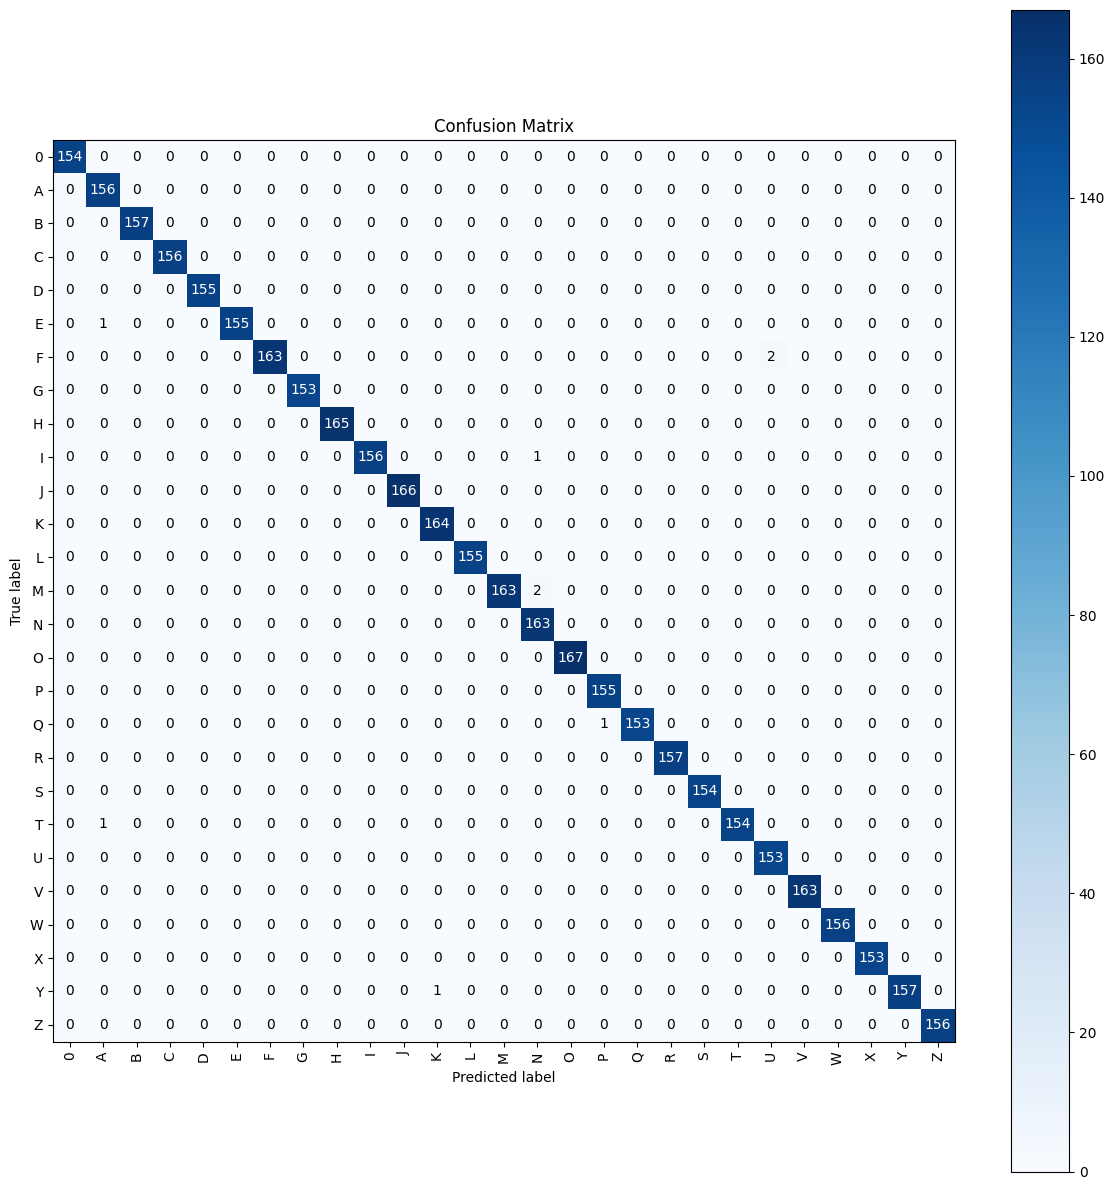

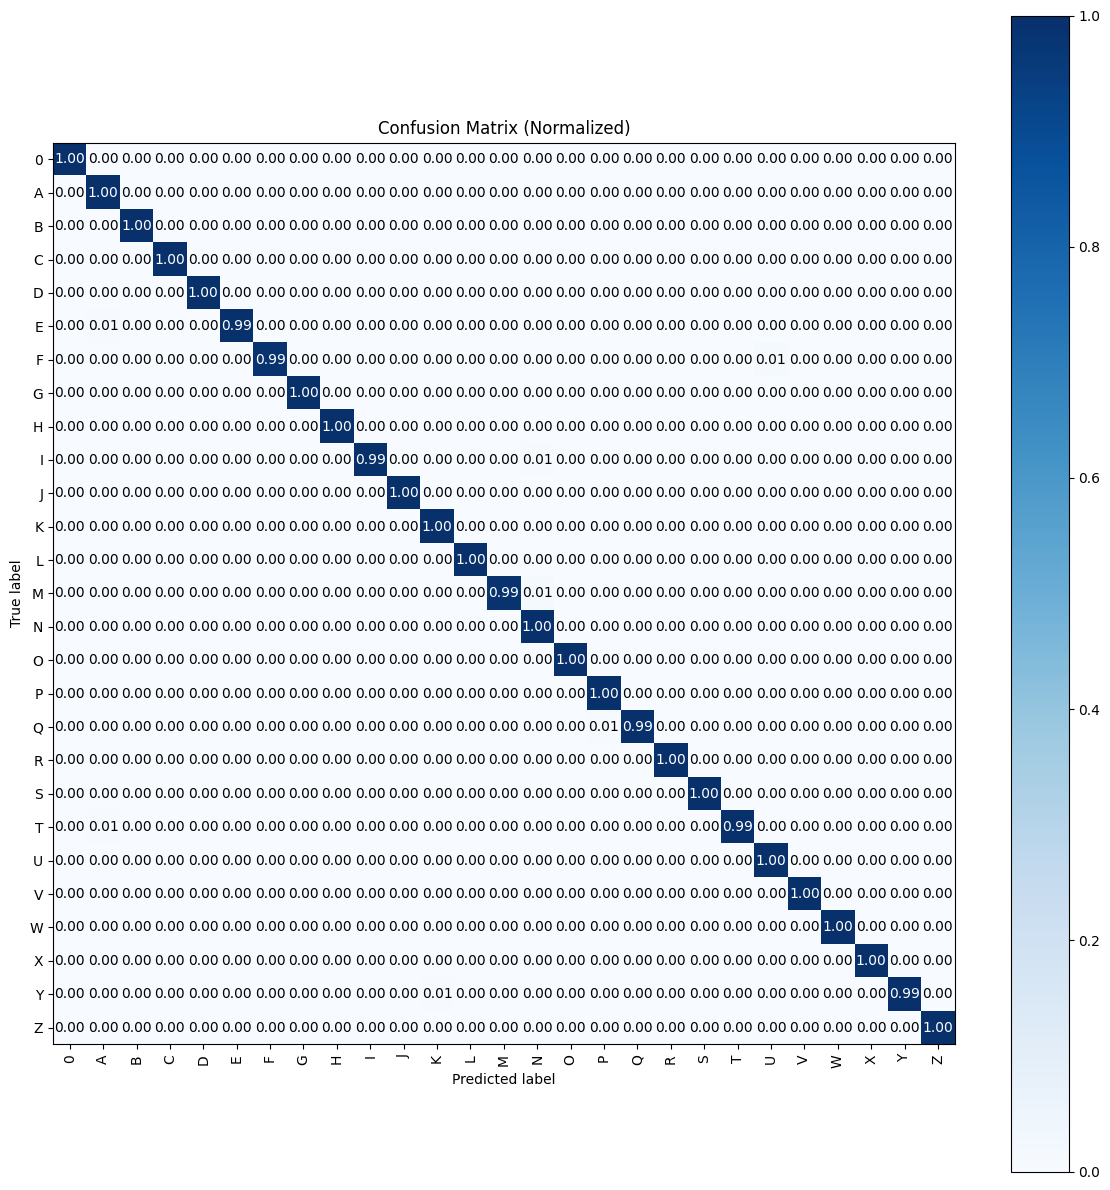

In [31]:
plot_confusion_matrix(cm, class_names, normalize=False)
plot_confusion_matrix(cm, class_names, normalize=True)
